In [1]:
import os, sys
from random import randint, shuffle, seed
import numpy as np
import math
import time
from collections import defaultdict
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from IPython.display import clear_output
from c2048 import Game, push
import matplotlib
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import optimizers, cuda
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
%matplotlib notebook

In [2]:
class Model(chainer.Chain):
    def __init__(self):
        super(Model, self).__init__()
        
        with self.init_scope():
            self.l1_a = L.Convolution2D(None, 512, (2, 1), pad=0)
            self.l1_b = L.Convolution2D(None, 512, (1, 2), pad=0)
            self.l2_a = L.Convolution2D(512, 4096, (2, 1), pad=0)
            self.l2_b = L.Convolution2D(512, 4096, (1, 2), pad=0)
            self.l3 = L.Linear(None, 1)
            
    def __call__(self, x):
        x_a = F.relu(self.l1_a(x))
        x_b = F.relu(self.l1_b(x))
        x_aa = F.relu(self.l2_a(x_a))
        x_bb = F.relu(self.l2_b(x_b))
        x_ab = F.relu(self.l2_b(x_a))
        x_ba = F.relu(self.l2_a(x_b))
        t = F.concat([t.reshape((x.shape[0], -1)) for t in [x_aa, x_ab, x_ba, x_bb, x_a, x_b]])
        t = self.l3(t)
        return t
model = Model()

In [3]:
optimizer = optimizers.Adam(alpha=1e-4)
optimizer.setup(model)

## GPU
gpu_device = 0
cuda.get_device(gpu_device).use()
model.to_gpu(gpu_device)
xp = cuda.cupy if gpu_device >= 0 else np

In [4]:
table ={2**i:i for i in range(1,16)}
table[0]=0
def make_ixput(grid):
    g0 = grid
    if gpu_device >= 0:
        g0 = cuda.to_cpu(g0)
    r = xp.zeros(shape=(16, 4, 4), dtype=xp.float32)
    for i in range(4):
        for j in range(4):
            v = g0[i, j]
            r[table[v],i, j]=1
    return r

In [5]:
logf=open("log", "w")
def printx(*a, **kw):
    print(*a, file=logf, flush=True, **kw)
    print(*a, flush=True, **kw)

In [6]:
def get_grid(driver):
    grid = xp.zeros(shape=(4,4), dtype='uint16')
    for x in driver.find_elements_by_class_name('tile'):
        cl = x.get_attribute('class').split()
        for t in cl:
            if t.startswith('tile-position-'):
                pos = int(t[14])-1, int(t[16])-1
            elif t.startswith('tile-') and t[5].isdigit():
                v = int(t[5:])
        grid[pos[1], pos[0]] = v
    return grid

In [7]:
def Vchange(grid, v):
    g0 = grid
    g1 = g0[:,::-1,:]
    g2 = g0[:,:,::-1]
    g3 = g2[:,::-1,:]
    r0 = grid.swapaxes(1,2)
    r1 = r0[:,::-1,:]
    r2 = r0[:,:,::-1]
    r3 = r2[:,::-1,:]
    xtrain = xp.array([g0,g1,g2,g3,r0,r1,r2,r3], dtype=xp.float32)
    ytrain = xp.array([v]*8, dtype=xp.float32)
    model.cleargrads()
    t = model(xtrain)
    ytrain = ytrain.reshape((len(ytrain), 1))
    loss = F.mean_squared_error(t, ytrain)
    loss.backward()
    optimizer.update()

arrow=[Keys.ARROW_LEFT, Keys.ARROW_UP, Keys.ARROW_RIGHT, Keys.ARROW_DOWN]
def gen_sample_and_learn(driver):
    body = driver.find_element_by_tag_name('body')
    game_len = 0
    game_score = 0
    last_grid = None
    keep_playing =False
    while True:
        try:
            grid_array = get_grid(driver)
        except:
            grid_array = None
        board_list = []
        if grid_array is not None:
            if not keep_playing and grid_array.max()==2048:
                driver.find_element_by_class_name('keep-playing-button').click()
                keep_playing = True
                time.sleep(1)
            for m in range(4):
                g = grid_array.copy()
                s = push(g, m%4)
                if s >= 0:
                    board_list.append( (g, m, s) )
        if board_list:
            boards = xp.array([make_ixput(g) for g,m,s in board_list], dtype=xp.float32)
            p = F.flatten(model(cuda.to_gpu(boards)))
            p = p.array
            game_len+=1
            best_move = -1
            best_v = None
            for i, (g,m,s) in enumerate(board_list):
                v = 2*s + p[i]
                if best_v is None or v > best_v:
                    best_v = v
                    best_move = m
                    best_score = 2*s
                    best_grid = boards[i]
            body.send_keys(arrow[best_move])
            game_score += best_score
        else:
            best_v = 0
            best_grid = None
        if last_grid is not None:
            Vchange(last_grid, best_v)       
        last_grid = best_grid
        if not board_list:
            break
        plt.pause(0.05)
    return game_len, int(grid_array.max()), int(game_score)

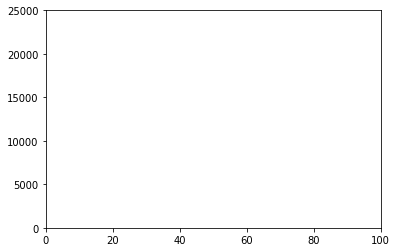

0 (171, 128, 1724)


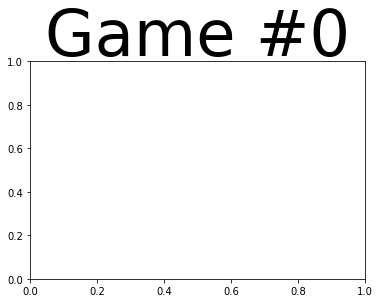

1 (149, 128, 1472)


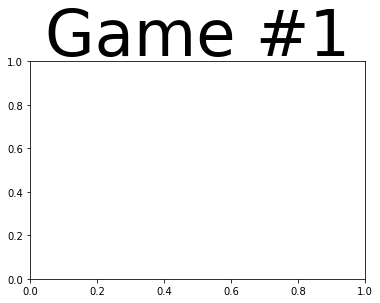

2 (220, 256, 2540)


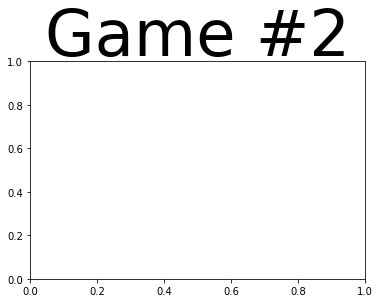

3 (165, 128, 1656)


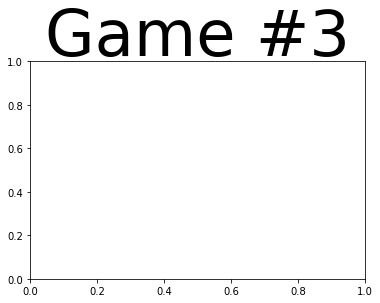

4 (232, 256, 2732)


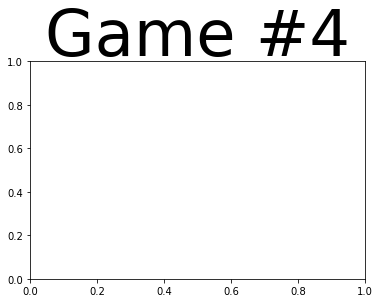

5 (113, 64, 912)


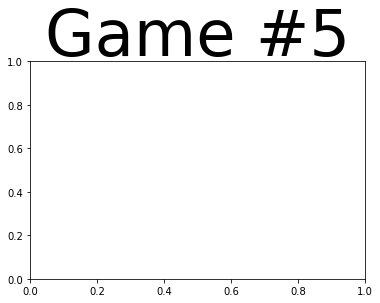

6 (91, 64, 676)


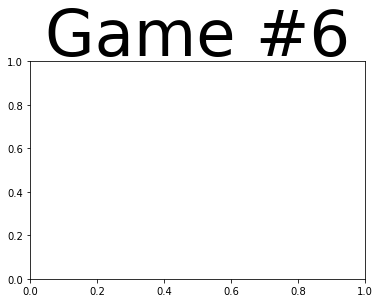

7 (168, 128, 1688)


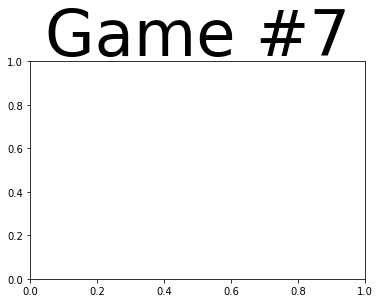

8 (251, 256, 3068)


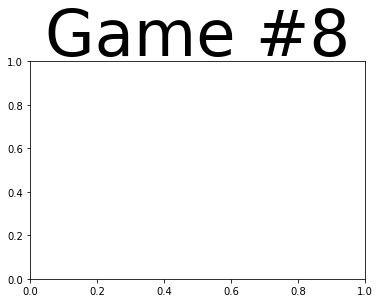

9 (141, 128, 1432)


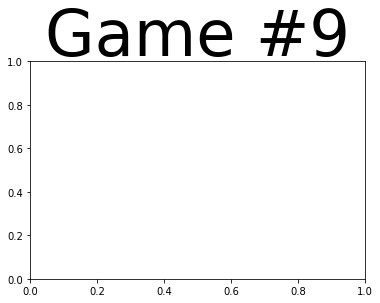

10 (286, 256, 3400)


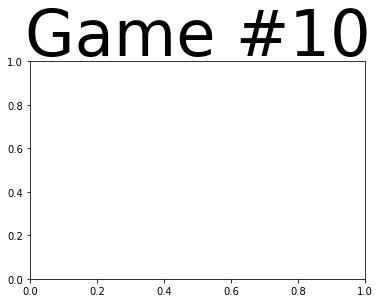

11 (180, 256, 2140)


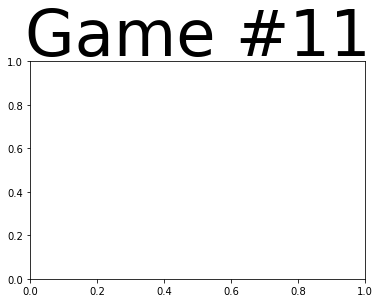

12 (206, 256, 2432)


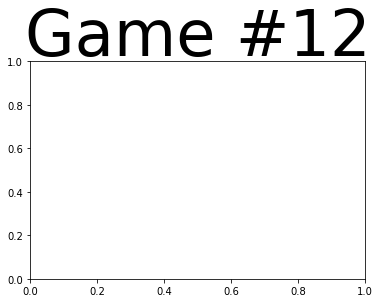

13 (193, 128, 1956)


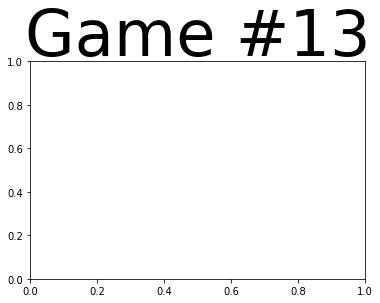

14 (322, 512, 4712)


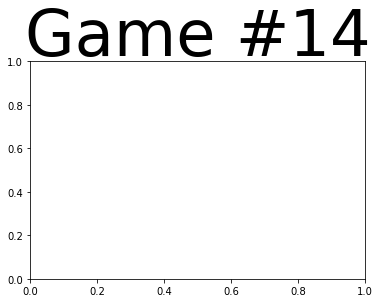

15 (283, 256, 3384)


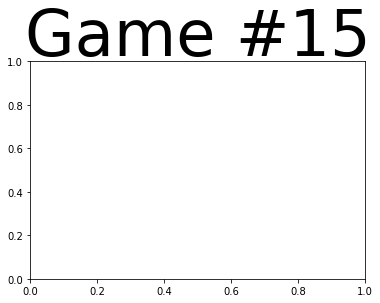

16 (170, 128, 1692)


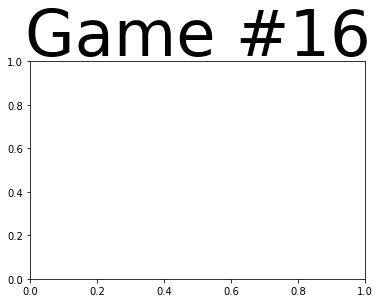

17 (262, 256, 3128)


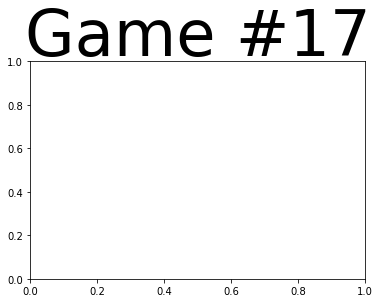

18 (154, 128, 1480)


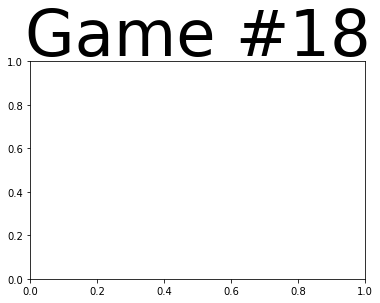

19 (234, 256, 2652)


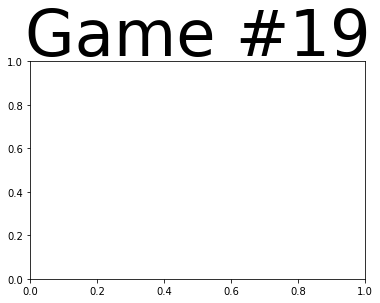

20 (301, 256, 3584)


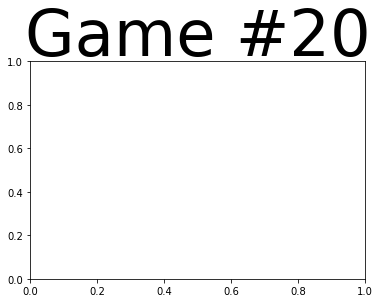

21 (276, 256, 3356)


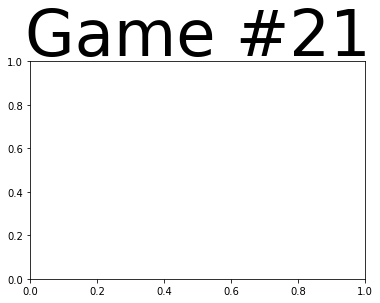

22 (370, 512, 5400)


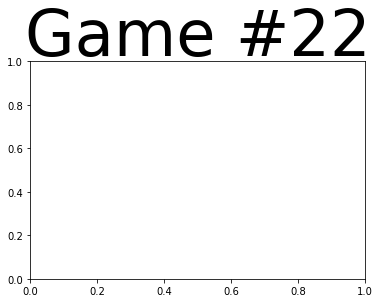

23 (384, 512, 5472)


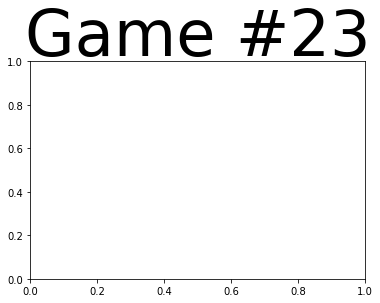

24 (283, 256, 3408)


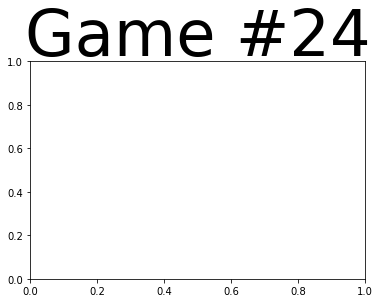

25 (284, 256, 3392)


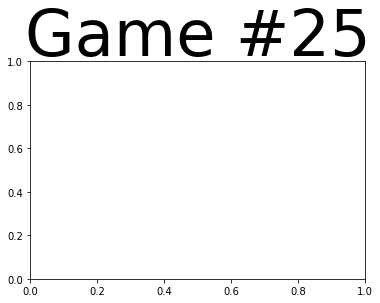

26 (480, 512, 6872)


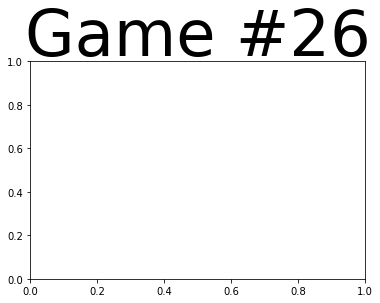

27 (161, 128, 1536)


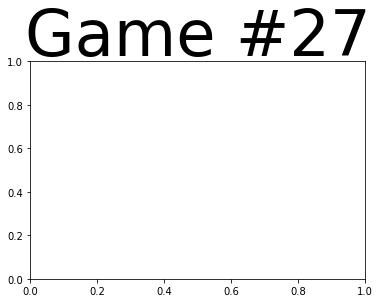

28 (296, 256, 3460)


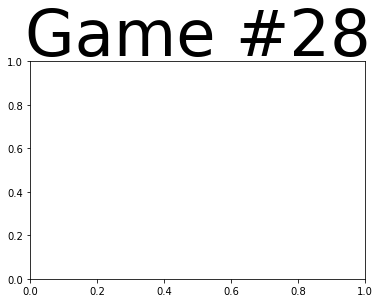

29 (288, 256, 3468)


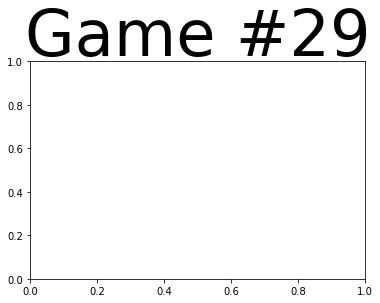

30 (266, 256, 3204)


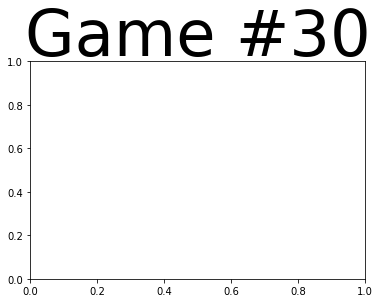

31 (277, 256, 3192)


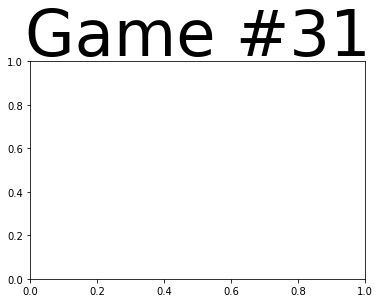

32 (168, 128, 1664)


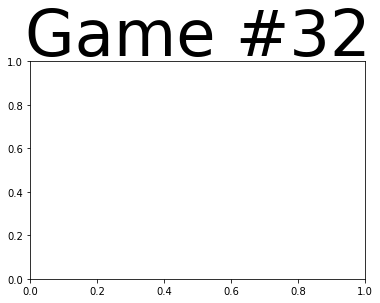

33 (429, 512, 6168)


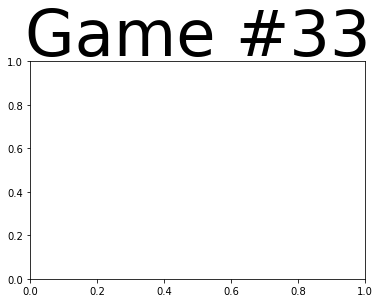

34 (352, 256, 4496)


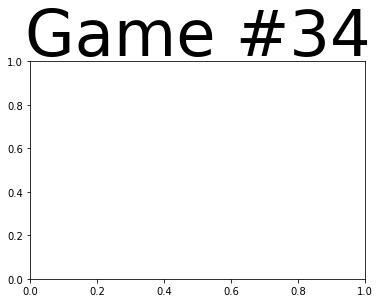

35 (497, 512, 7316)


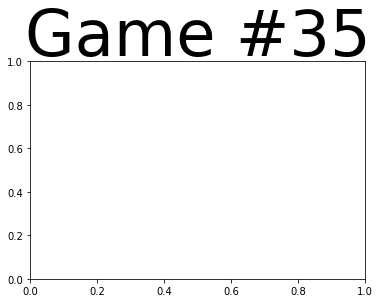

36 (292, 256, 3632)


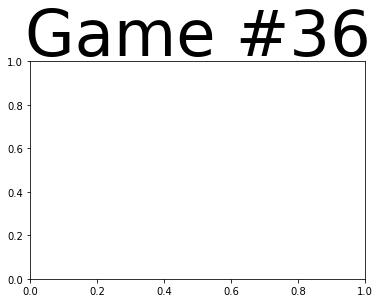

37 (497, 512, 7160)


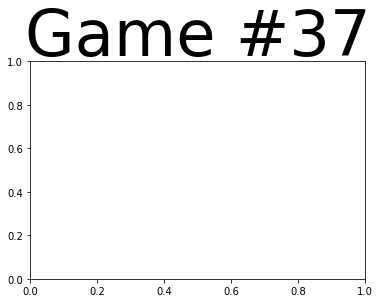

38 (265, 256, 3196)


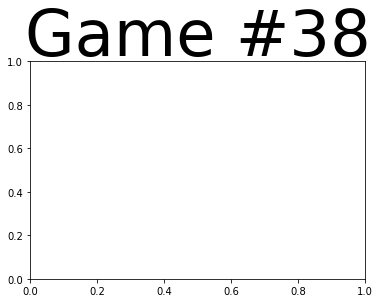

39 (293, 256, 3556)


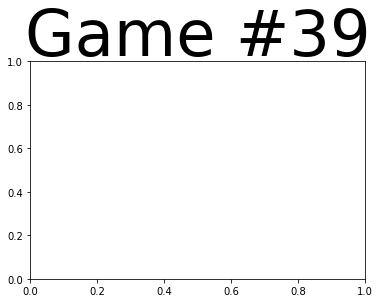

40 (442, 512, 6440)


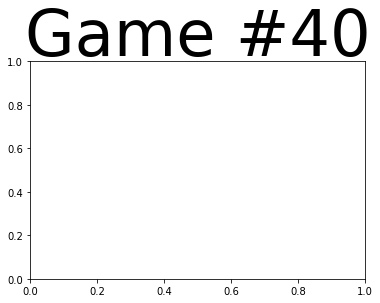

41 (292, 256, 3508)


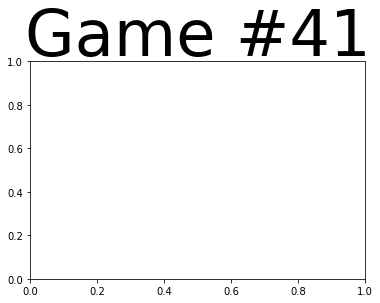

42 (285, 256, 3460)


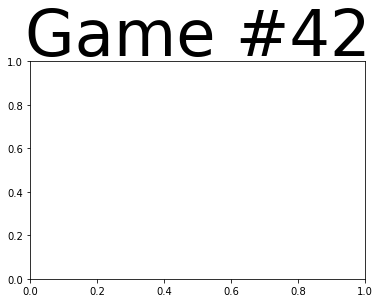

43 (293, 256, 3492)


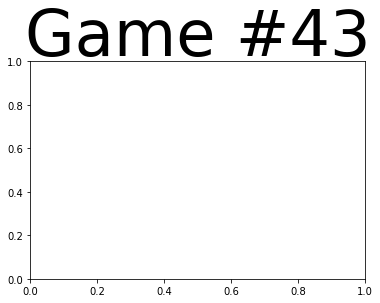

44 (386, 512, 5664)


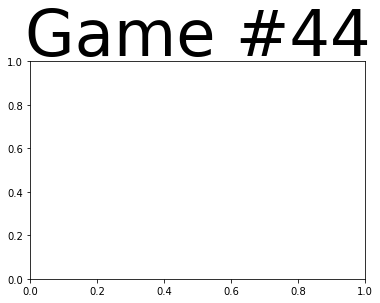

45 (262, 256, 3136)


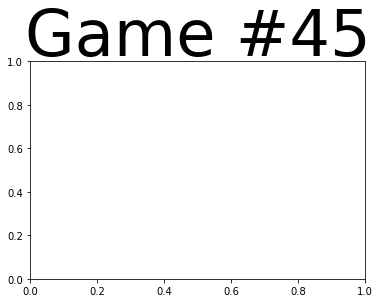

46 (518, 512, 7416)


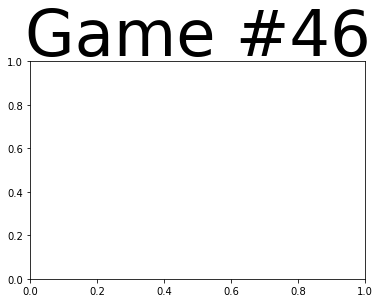

47 (517, 512, 7384)


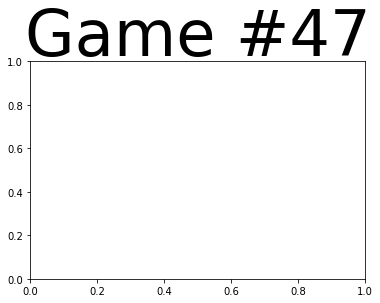

48 (287, 256, 3472)


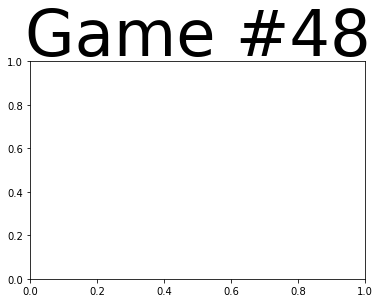

49 (458, 512, 6380)


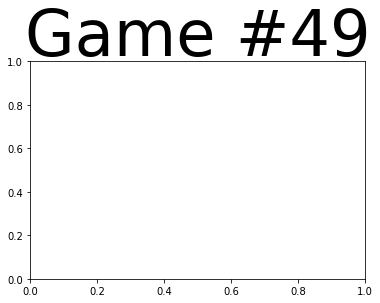

50 (642, 512, 9232)


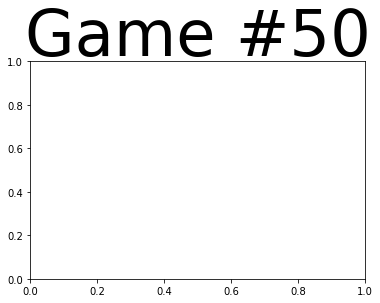

51 (489, 512, 7088)


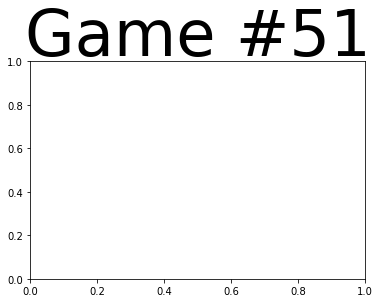

52 (698, 1024, 11900)


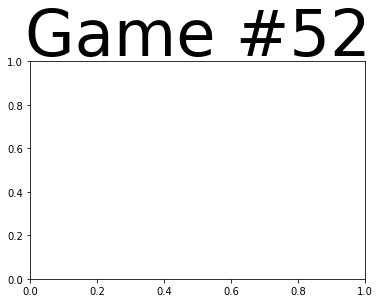

53 (290, 256, 3480)


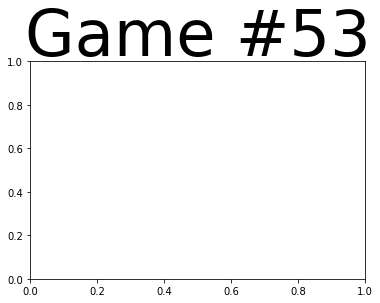

54 (423, 512, 6284)


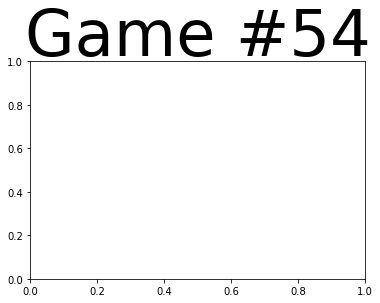

55 (491, 512, 7180)


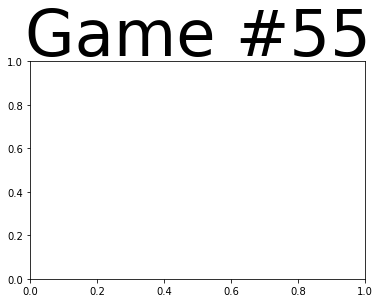

56 (488, 512, 7108)


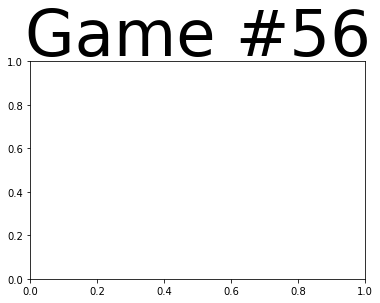

57 (569, 512, 8512)


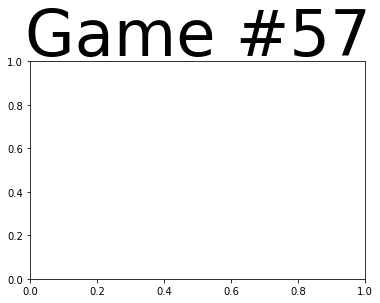

58 (315, 256, 3904)


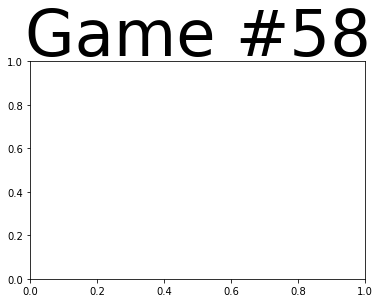

59 (438, 512, 6420)


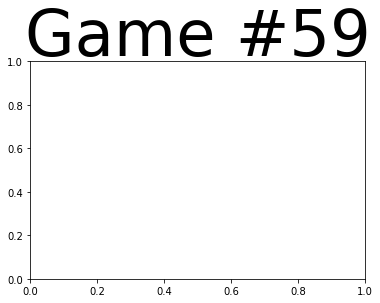

60 (309, 256, 3672)


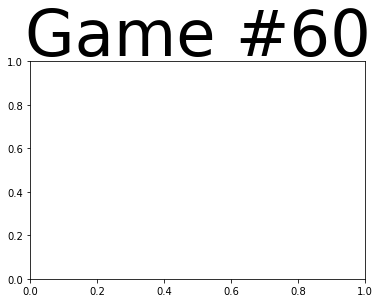

61 (161, 128, 1556)


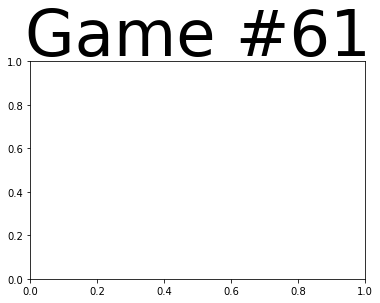

62 (537, 512, 7752)


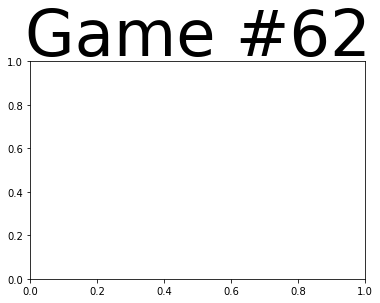

63 (695, 512, 10724)


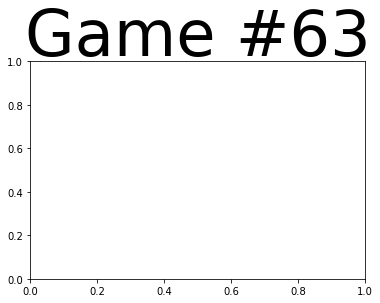

64 (501, 512, 7456)


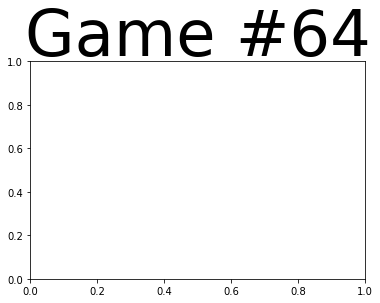

65 (622, 1024, 10692)


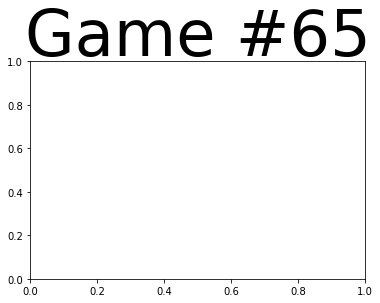

66 (841, 1024, 14456)


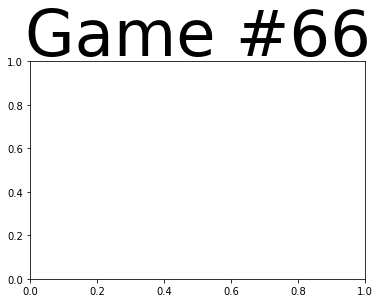

67 (345, 512, 5088)


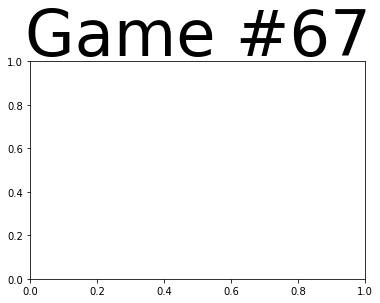

68 (415, 512, 5788)


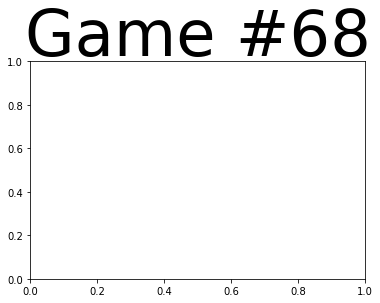

69 (519, 512, 7392)


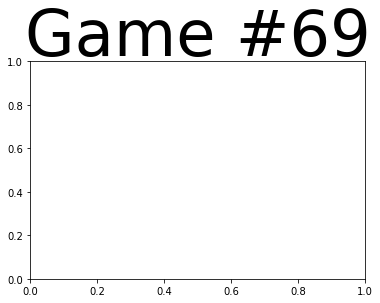

70 (321, 256, 3924)


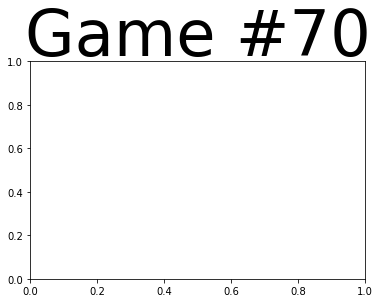

71 (506, 512, 7268)


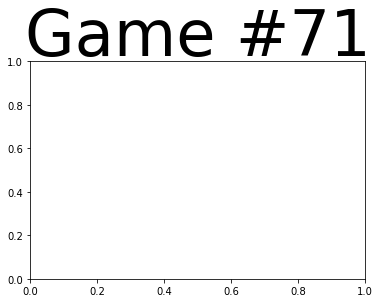

72 (329, 256, 4024)


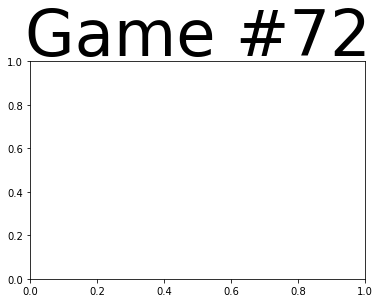

73 (278, 256, 3324)


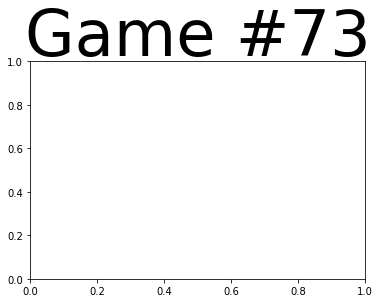

74 (727, 1024, 12204)


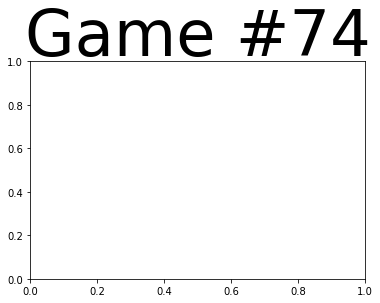

75 (362, 512, 5224)


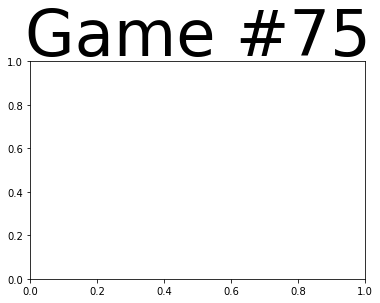

76 (436, 512, 6160)


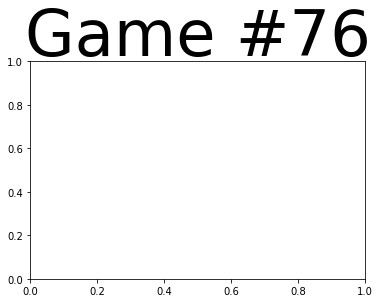

77 (151, 128, 1444)


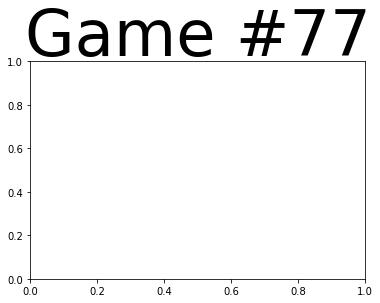

78 (416, 256, 5268)


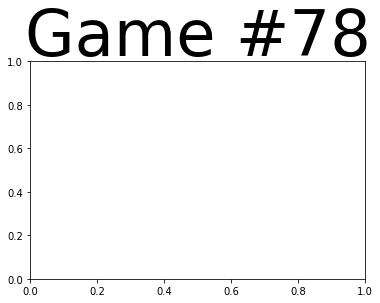

79 (398, 512, 5660)


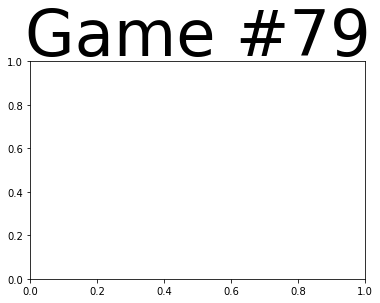

80 (275, 256, 3352)


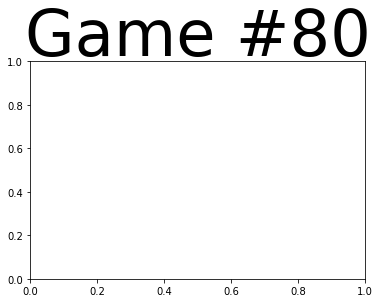

81 (416, 512, 5780)


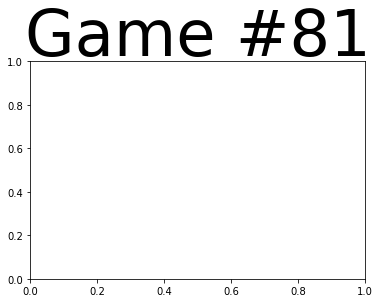

83 (336, 256, 4112)


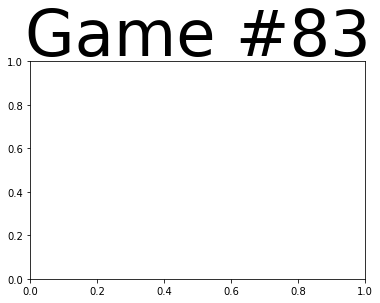

84 (275, 256, 3332)


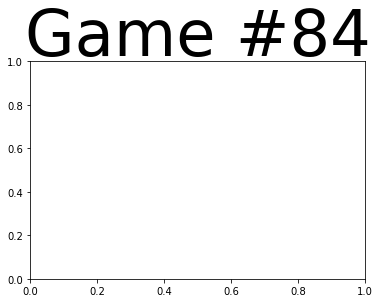

85 (507, 512, 7340)


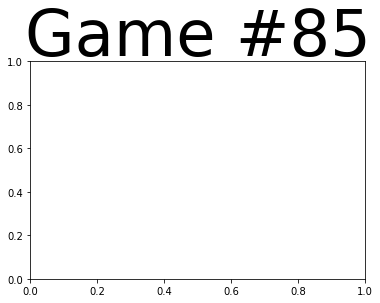

86 (629, 512, 9124)


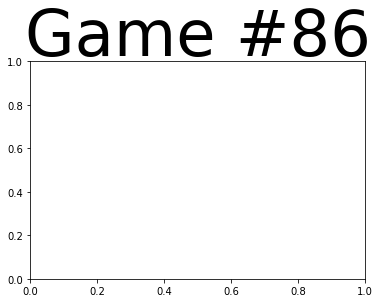

87 (757, 512, 11496)


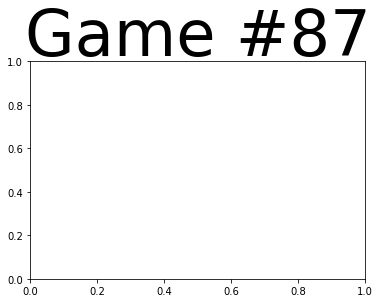

88 (609, 512, 9448)


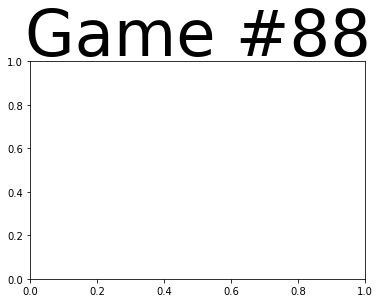

89 (438, 512, 6532)


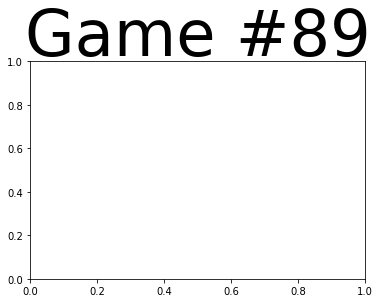

90 (423, 512, 5912)


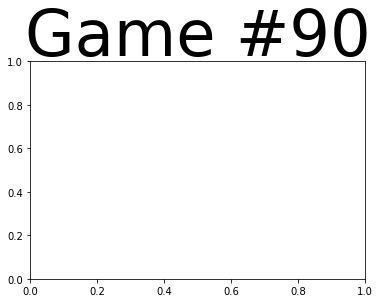

91 (403, 512, 5696)


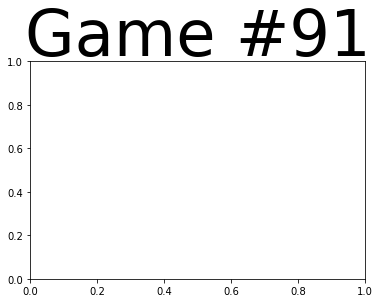

92 (207, 128, 2172)


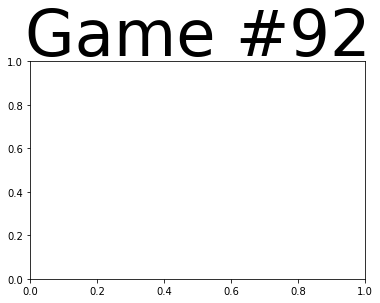

93 (352, 256, 4644)


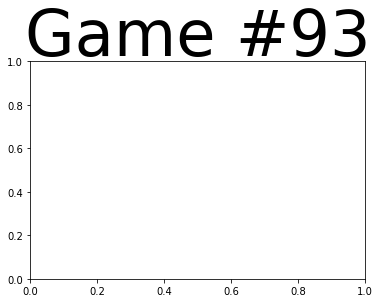

94 (340, 256, 4276)


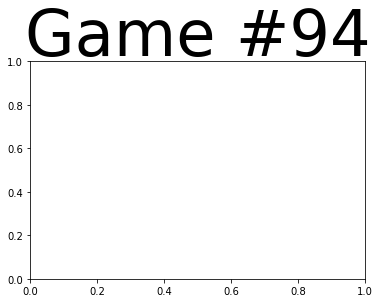

95 (323, 256, 3956)


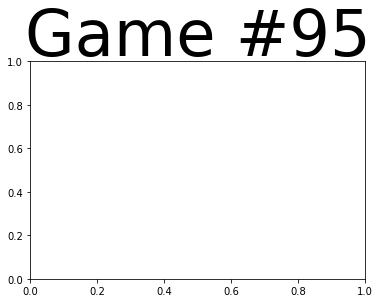

96 (487, 512, 7100)


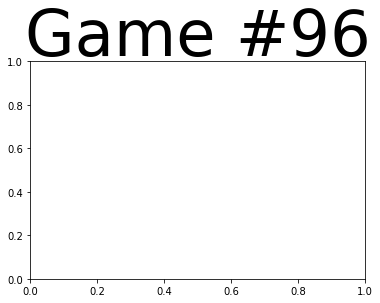

97 (424, 512, 5936)


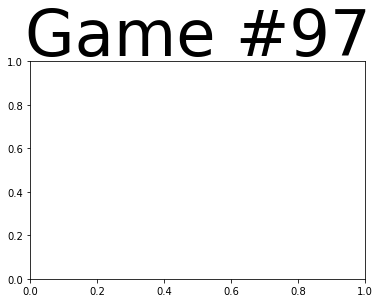

98 (300, 256, 3616)


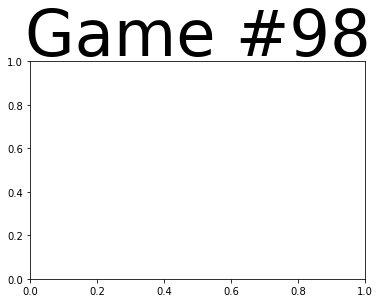

99 (447, 512, 6352)


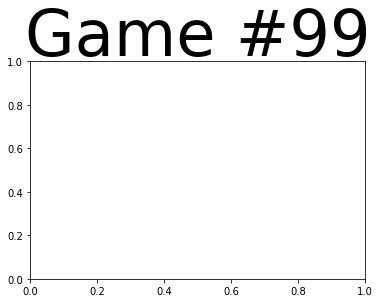

100 (291, 256, 3616)


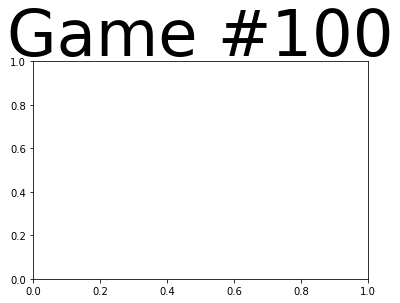

101 (330, 256, 4004)


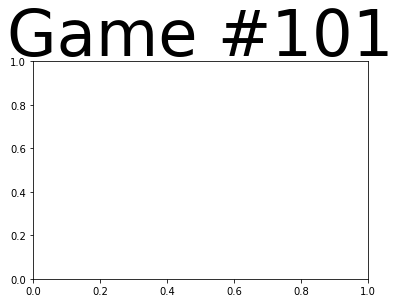

102 (307, 256, 3800)


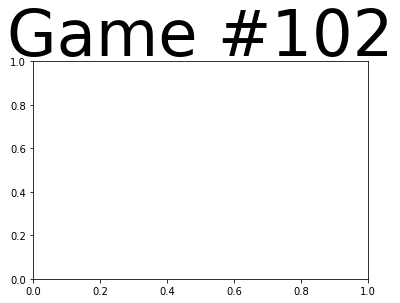

In [ ]:
results = []
driver = webdriver.Firefox()
graph = plt.plot([], [], 'b')[0]
dots256 = plt.plot([],[], 'ro')[0]
dots512 = plt.plot([],[], 'yo')[0]
dots1024 = plt.plot([],[], 'go')[0]
plt.xlim((0,100))
plt.ylim((0,25000))
for j in range(200):
    driver.get("https://gabrielecirulli.github.io/2048/")
    time.sleep(2)
    result = gen_sample_and_learn(driver)
    print(j, result)
    results.append(result)
    graph.set_data(np.arange(len(results)), np.array(results)[:, 2])
    dots_data =[[],[],[]]
    for i, d in enumerate(results):
        c = 0 if d[1]<=256 else (1 if d[1]==512 else 2)
        dots_data[c].append([i, d[2]])
    dots_graph = [dots256, dots512, dots1024]
    for i in range(3):
        if dots_data[i]:
            xy = np.array(dots_data[i])
            dots_graph[i].set_data(xy[:, 0], xy[:,1])
    plt.title("Game #%d"%j, fontsize=64)
    plt.draw()
    plt.pause(3)
    if result[1] >= 2048:
        break

In [ ]:
from chainer import serializers
serializers.save_npz("mymodel.npz", model)

In [ ]:
model.to_cpu()
serializers.save_npz("model_cpu.npz", model)